## Laura Hoffmann

Online travel agencies are scrambling to meet the artificial intelligence driven personalization standard set by companies like Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.
 
The data set can be found at Kaggle: Expedia Hotel Recommendations. To get started, I would suggest exploring the file train.csv, which contains the logs of user behavior.  There is another file named destinations.csv, which contains information related to hotel reviews made by users. There is a lot of data here, and making an accurate prediction is rather difficult, e.g., simply running a standard prediction algorithm will probably yield below 10% accuracy. Start by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv). Then, build at least two prediction models from the training set, and report the accuracies on the test set. As I mentioned, this is a difficult problem, so be creative with your solutions. You might want to try building your own predictor rather than a standard predictor model, e.g., a random forest.  The purpose of this project is not necessarily to get great results but to understand the nuances and challenges of such problems.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [2]:
# Read training data
train = pd.read_csv('train.csv', nrows = 100000)

# Read testing data
test = pd.read_csv('test.csv', nrows=100000)

# Read destination data
destination = pd.read_csv('destinations.csv', nrows=100000)

In [3]:
# Preview training data
train.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


### EDA

Stary by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select.

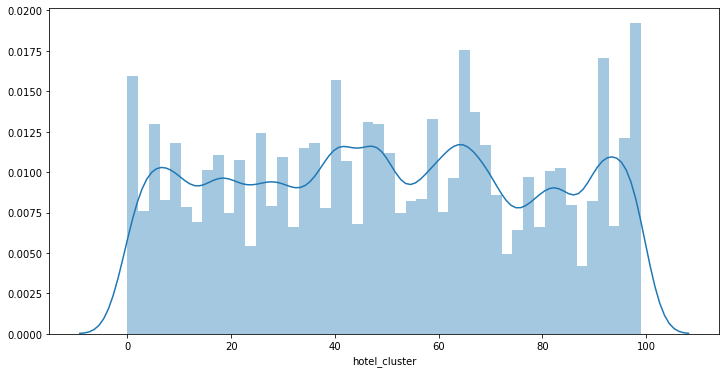

In [4]:
# Plot distribution of hotel_cluster variable
plt.figure(figsize=(12, 6))
sns.distplot(train['hotel_cluster'])

### Feature Selection and Creation

Extracting years and months from the date_time column

In [5]:
# Function to extract the year
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

# Function to extract the month
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

In [6]:
# Creating new columns for date_time years and months
train['date_time_year'] = pd.Series(train.date_time, index = train.index)
train['date_time_month'] = pd.Series(train.date_time, index = train.index)

# Convert date_time year and months to int using get_year and get_month funtions
train.date_time_year = train.date_time_year.apply(lambda x: get_year(x))
train.date_time_month = train.date_time_month.apply(lambda x: get_month(x))

# Remove the date_time column
del train['date_time']

In [7]:
# Creating new columns for checkin years and months
train['srch_ci_year'] = pd.Series(train.srch_ci, index=train.index)
train['srch_ci_month'] = pd.Series(train.srch_ci, index=train.index)

# Convert checkin year and months to int using get_year and get_month funtions
train.srch_ci_year = train.srch_ci_year.apply(lambda x: get_year(x))
train.srch_ci_month = train.srch_ci_month.apply(lambda x: get_month(x))

# Remove the srch_ci column
del train['srch_ci']

In [8]:
# Creating new columns for checkout years and months
train['srch_co_year'] = pd.Series(train.srch_co, index=train.index)
train['srch_co_month'] = pd.Series(train.srch_co, index=train.index)

# Convert checkout year and months to int using get_year and get_month funtions
train.srch_co_year = train.srch_co_year.apply(lambda x: get_year(x))
train.srch_co_month = train.srch_co_month.apply(lambda x: get_month(x))

# Remove the srch_co column
del train['srch_co']

### Analysis

Correlations

In [9]:
# View correlations between each of the columns and the hotel_cluster column
train.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.030064
is_booking                  -0.025380
user_location_country       -0.025170
hotel_country               -0.021170
site_name                   -0.019154
hotel_continent             -0.008441
srch_destination_id         -0.007258
user_location_city          -0.006580
channel                     -0.005956
srch_rm_cnt                 -0.005801
is_mobile                   -0.002803
srch_co_month               -0.000413
date_time_year               0.000696
cnt                          0.000914
date_time_month              0.001208
user_id                      0.001396
srch_ci_month                0.001682
posa_continent               0.002204
srch_children_cnt            0.005469
srch_adults_cnt              0.007322
user_location_region         0.008037
srch_ci_year                 0.010879
orig_destination_distance    0.011362
srch_co_year                 0.012014
hotel_market                 0.036107
is_package                   0.051955
hotel_cluste

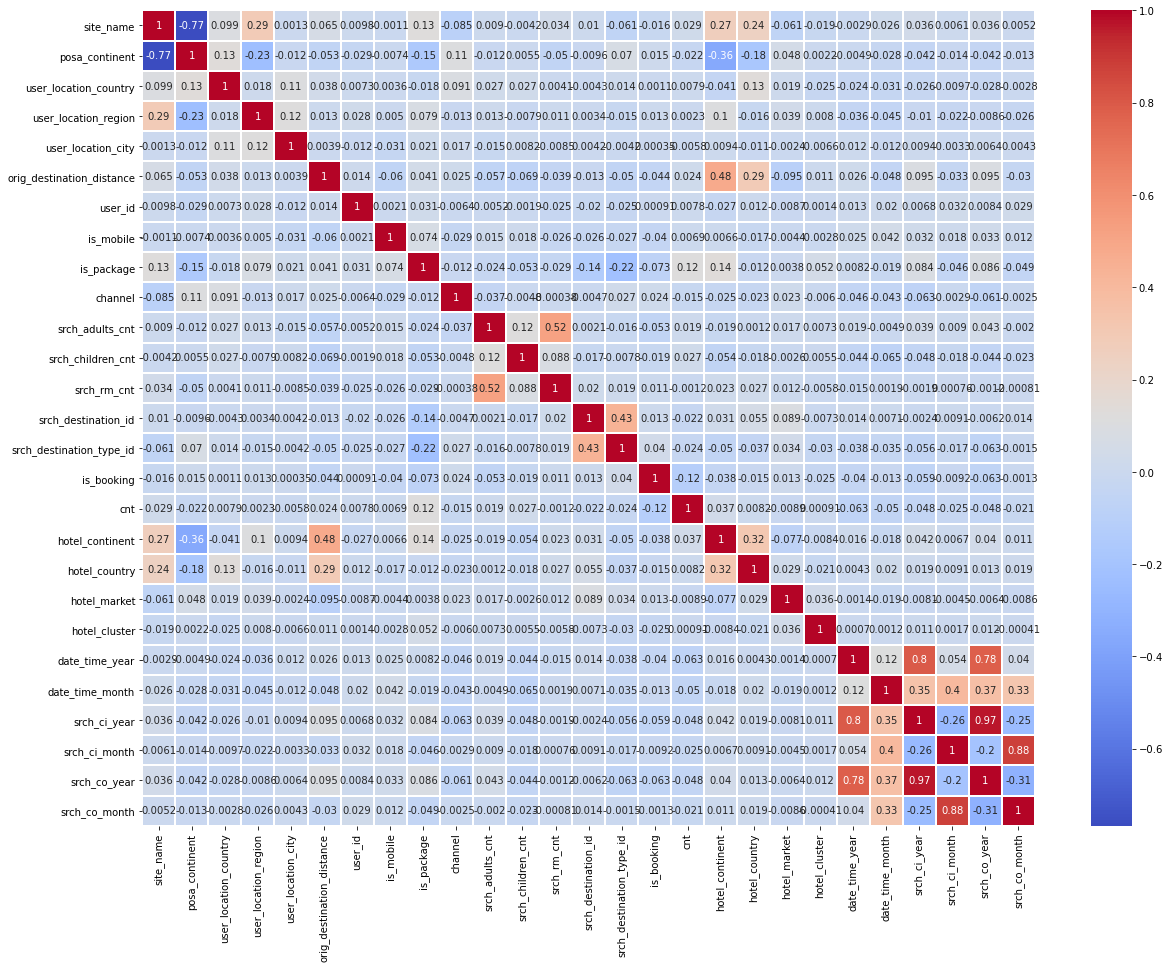

In [10]:
# Correlations on a heatmap
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
sns.heatmap(train.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=1)

Above we can see correlations between all of the predicting variables and since some are highly correlated (for instance check in & check out months and check in & check out years) we can remove one from the analysis. So for the models, check out month and year variables will be removed, as well as the date_time year and month columns.

#### Creating a pivot table to help map each of the hotel clusters

In [11]:
# Groupby search, country and market to help determine cluster
predictors = [train.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
sums = pd.concat(predictors).groupby(level=[0,1,2,3]).sum()
sums.dropna(inplace=True)
sums.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          32               1      2
                                               60               0      1
                                               77               1      2
11                  50            824          94               1      2
14                  27            1434         20               1      3

In [12]:
# Create new column in the groupby table
sums['sum_and_cnt'] = 0.85*sums['sum'] + 0.15*sums['count']
sums = sums.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
sums.reset_index(inplace=True)
sums.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,32,0.5,0.4,0.469388
1,8,50,416,60,0.0,0.2,0.061224
2,8,50,416,77,0.5,0.4,0.469388
3,11,50,824,94,1.0,1.0,1.000000
4,14,27,1434,20,1.0,0.6,0.812500


In [13]:
# Create the pivot table
pivot = sums.pivot_table(index=['srch_destination_id', 'hotel_country', 'hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,102,1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Keeping only bookings from the original data frame
df = train.loc[train['is_booking'] == 1]

In [15]:
# Merge data sets and pivot table
df = pd.merge(df, destination, how='left', on='srch_destination_id')
df = pd.merge(df, pivot, how='left', on=['srch_destination_id', 'hotel_country', 'hotel_market'])
df.fillna(0, inplace=True)
df.shape

(8270, 276)

In [16]:
# Setting the predictor variables (highly correlated variables removed as well)
X = df.drop(['user_id', 'hotel_cluster', 'is_booking', 'srch_co_month', 'srch_co_year', 'date_time_year', 'date_time_month'], axis=1)
# Setting the target variable
y = df.hotel_cluster

In [17]:
# Divide into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 6202
Testing Data Count: 2068


## Modeling
### Naive Bayes

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
naiveb = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(naiveb, X, y, cv=10))

0.12708585247883916

In [20]:
# Create Gaussian Naive Bayes classifier
gnb = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
# Fit the classifier to the data
gnb.fit(X_train, y_train)
# Check the accuracy
gnb.score(X_test, y_test)

0.13297872340425532

Well that accuracy is absolutely awful so lets try a different one

### K-Nearest Neighbors Classifier

In [21]:
knnclass = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=3))
np.mean(cross_val_score(knnclass, X, y, cv=10, scoring='accuracy'))

0.3110036275695285

In [22]:
# Create KNN classifier
knn = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=3))
# Fit the classifier to the data
knn.fit(X_train,y_train)
# Check the accuracy
knn.score(X_test, y_test)

0.31963249516441006

### Random Forest Classifier

In [23]:
rfclass = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0))
np.mean(cross_val_score(rfclass, X, y, cv=10))

0.30048367593712216

In [24]:
# Create random forest classifier
rfc = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0))
# Fit the clasifier to the data
rfc.fit(X_train, y_train)
# Check the accuracy
rfc.score(X_test, y_test)

0.30802707930367507

### Support Vector Machine

In [25]:
svmachine = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(svmachine, X, y, cv=10))

0.3996372430471584

In [26]:
# Create support vector machine
svmmodel = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
# Fit the model to the data
svmmodel.fit(X_train, y_train)
# Check the accuracy
svmmodel.score(X_test, y_test)

0.40425531914893614